In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# Data Loading and Preprocessing

In [2]:
# Load the dataset
data = pd.read_csv('stock_price.csv')

# Display the first few rows to verify
data.head()


,日付け,終値,始値,高値,安値,出来高,変化率 %
0,2024-08-01,156.3,159.3,159.4,156.1,79.15M,-2.56%
1,2024-07-31,160.4,158.2,160.7,158.1,173.91M,1.07%
2,2024-07-30,158.7,158.8,159.2,158.0,138.14M,-0.63%
3,2024-07-29,159.7,158.7,160.2,158.4,126.28M,1.14%
4,2024-07-26,157.9,159.3,159.6,157.9,155.08M,-0.13%


## Renaming columns to English

In [3]:
# Rename columns
data.columns = ['Date', 'Close Price', 'Open Price', 'High Price', 'Low Price', 'Volume', 'Change Rate %']

# Display the updated columns
print(data.columns)


Index(['Date', 'Close Price', 'Open Price', 'High Price', 'Low Price',
       'Volume', 'Change Rate %'],
      dtype='object')


## Data type conversion and Cleaning

In [4]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Handle 'Volume' column (convert from strings like '79.15M' to numerical values)
def convert_volume(value):
    if 'M' in value:
        return float(value.replace('M', '')) * 1e6
    elif 'B' in value:
        return float(value.replace('B', '')) * 1e9
    else:
        return float(value)

data['Volume'] = data['Volume'].apply(convert_volume)

# Convert 'Change Rate %' to numeric by removing '%' and converting to decimal
data['Change Rate %'] = data['Change Rate %'].str.replace('%', '').astype(float) / 100

# Convert price columns to numeric
price_columns = ['Close Price', 'Open Price', 'High Price', 'Low Price']
for col in price_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Check for missing values
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)


Missing values:
 Date             0
Close Price      0
Open Price       0
High Price       0
Low Price        0
Volume           0
Change Rate %    0
dtype: int64


# Handling Missing values

In [5]:
# Drop rows with missing values
data.dropna(inplace=True)

# Verify that there are no more missing values
print("Missing values after dropping:\n", data.isnull().sum())


Missing values after dropping:
 Date             0
Close Price      0
Open Price       0
High Price       0
Low Price        0
Volume           0
Change Rate %    0
dtype: int64


# Exploratory Data Analysis (EDA)

## Desriptive Statistics

In [6]:
# Get basic statistics
statistics = data.describe()
print(statistics)


                                Date  Close Price   Open Price   High Price  \
count                           9202  9202.000000  9202.000000  9202.000000   
mean   2005-10-21 08:44:04.642469248    92.180961    92.256183    93.176451   
min              1987-02-12 00:00:00    33.000000    33.000000    33.200000   
25%              1996-06-06 06:00:00    52.000000    52.100000    52.800000   
50%              2005-10-11 12:00:00    85.100000    85.100000    86.050000   
75%              2015-03-04 18:00:00   110.800000   110.800000   111.900000   
max              2024-08-01 00:00:00   305.900000   309.800000   311.800000   
std                              NaN    50.452228    50.598215    51.049837   

         Low Price        Volume  Change Rate %  
count  9202.000000  9.202000e+03    9202.000000  
mean     91.330146  1.726677e+08       0.000175  
min      32.200000  9.340000e+06      -0.147400  
25%      51.500000  8.073000e+07      -0.009400  
50%      84.200000  1.540150e+08      

## Plotting the Closing Price and Volume Over Time

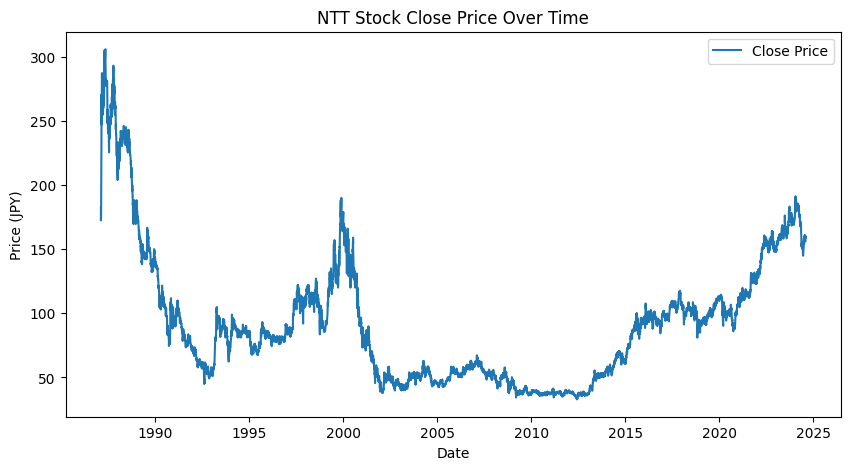

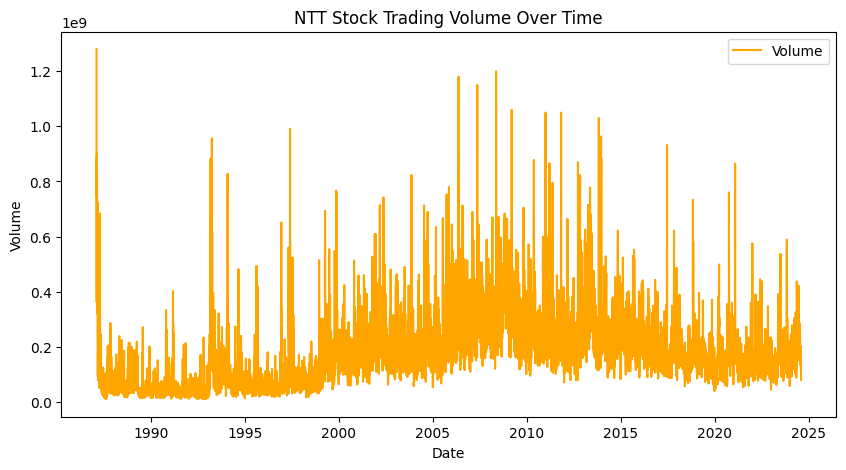

In [7]:
# Plot Close Price over time
plt.figure(figsize=(10, 5))
plt.plot(data['Date'], data['Close Price'], label='Close Price')
plt.title('NTT Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (JPY)')
plt.legend()
plt.show()

# Plot Volume over time
plt.figure(figsize=(10, 5))
plt.plot(data['Date'], data['Volume'], label='Volume', color='orange')
plt.title('NTT Stock Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()


## Correlation Matrix

In [8]:
# Compute correlation matrix
correlation = data[['Close Price', 'Open Price', 'High Price', 'Low Price', 'Volume', 'Change Rate %']].corr()
print("Correlation Matrix:\n", correlation)


Correlation Matrix:
                Close Price  Open Price  High Price  Low Price    Volume  \
Close Price       1.000000    0.999547    0.999795   0.999754 -0.317508   
Open Price        0.999547    1.000000    0.999755   0.999791 -0.320279   
High Price        0.999795    0.999755    1.000000   0.999660 -0.315402   
Low Price         0.999754    0.999791    0.999660   1.000000 -0.322392   
Volume           -0.317508   -0.320279   -0.315402  -0.322392  1.000000   
Change Rate %     0.017166   -0.002860    0.007792   0.005815  0.130238   

               Change Rate %  
Close Price         0.017166  
Open Price         -0.002860  
High Price          0.007792  
Low Price           0.005815  
Volume              0.130238  
Change Rate %       1.000000  


## Seasonal Decomposition

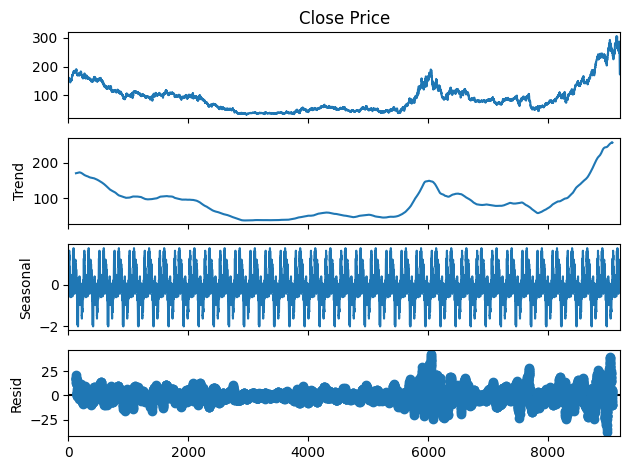

In [9]:
# Set 'Date' as index
# data.set_index('Date', inplace=True)

# Perform seasonal decomposition
result = seasonal_decompose(data['Close Price'], model='additive', period=252)  # Approximate number of trading days in a year

# Plot the decomposition
result.plot()
plt.show()


# Data Preperation for Modelling

## Split Data into Training and Testing Sets

In [10]:
# Reset index to use integer indices for splitting
# data.reset_index(inplace=True)

# Define the training data size (80%)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Print the sizes of the splits
print("Training data size:", len(train_data))
print("Testing data size:", len(test_data))


Training data size: 7361
Testing data size: 1841


# LSTM Model

## Data Scaling

In [11]:
# Use 'Close Price' column for LSTM model
close_prices = data['Close Price'].values.reshape(-1, 1)

# Scale data to range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(close_prices)

# Prepare training data
train_scaled = scaled_close[:train_size]
test_scaled = scaled_close[train_size:]


## Creating Datasets for LSTM

In [12]:
# Create sequences of 60 timesteps (you can adjust this window size)
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i - time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

# Create training and testing datasets
X_train, y_train = create_dataset(train_scaled)
X_test, y_test = create_dataset(np.concatenate((train_scaled[-60:], test_scaled)))

# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


## Building the LSTM Model

In [13]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(units=25))
lstm_model.add(Dense(units=1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32)


c:\WorkSpace\Tech Japan OA test\Assignment\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.0036
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 1.4424e-04
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 1.2065e-04
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 1.3018e-04
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 1.0732e-04
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 9.4581e-05
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 1.0428e-04
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 1.0621e-04
Epoch 9/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 8.9498e-05
Epoch 10/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 8.2731e-05


## Making Predictions with LSTM

In [14]:
# Make predictions
lstm_predictions_scaled = lstm_model.predict(X_test)

# Inverse transform to get actual prices
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

# Prepare actual prices for comparison
actual_prices = close_prices[train_size:]

# Ensure the lengths match
print("Length of actual prices:", len(actual_prices))
print("Length of predictions:", len(lstm_predictions))


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Length of actual prices: 1841
Length of predictions: 1841


## Plotting LSTM Predictions


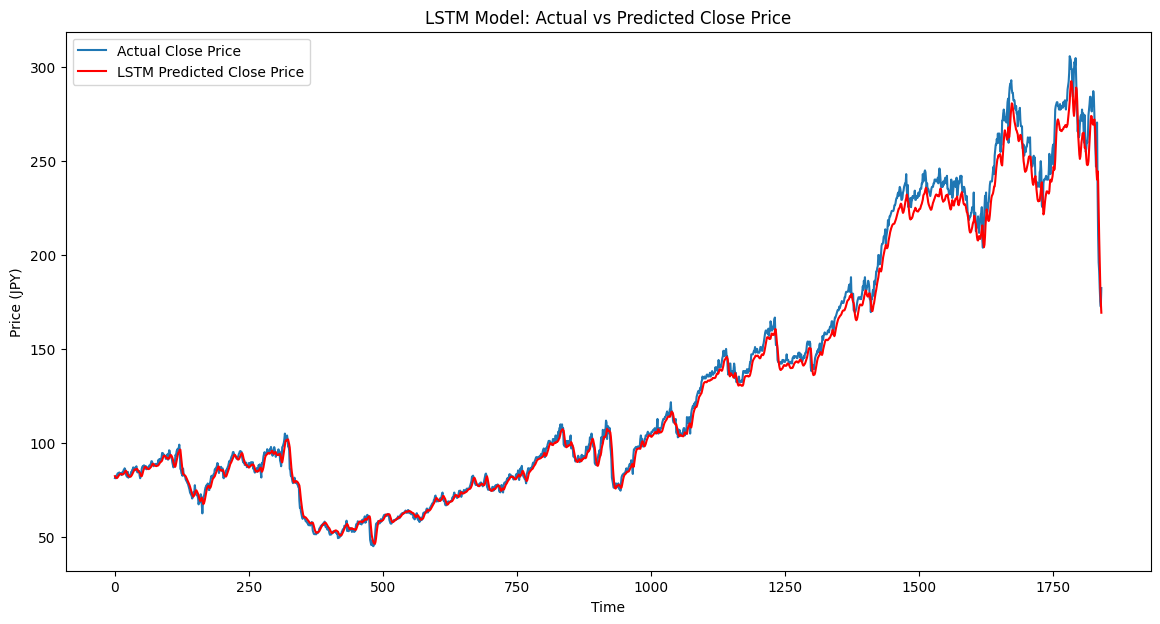

In [15]:
# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(actual_prices, label='Actual Close Price')
plt.plot(lstm_predictions, label='LSTM Predicted Close Price', color='red')
plt.title('LSTM Model: Actual vs Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Price (JPY)')
plt.legend()
plt.show()


## Evaluating LSTM Model

In [16]:

# Calculate evaluation metrics
lstm_mae = mean_absolute_error(actual_prices, lstm_predictions)
lstm_mse = mean_squared_error(actual_prices, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)

print(f'LSTM Model MAE: {lstm_mae}')
print(f'LSTM Model MSE: {lstm_mse}')
print(f'LSTM Model RMSE: {lstm_rmse}')



LSTM Model MAE: 4.16000335709936
LSTM Model MSE: 36.232068520427426
LSTM Model RMSE: 6.01930797687138


#ARIMA

In [17]:
from statsmodels.tsa.stattools import adfuller

# ADF test
result = adfuller(train_data['Close Price'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -2.204215756118543
p-value: 0.20471894024096476


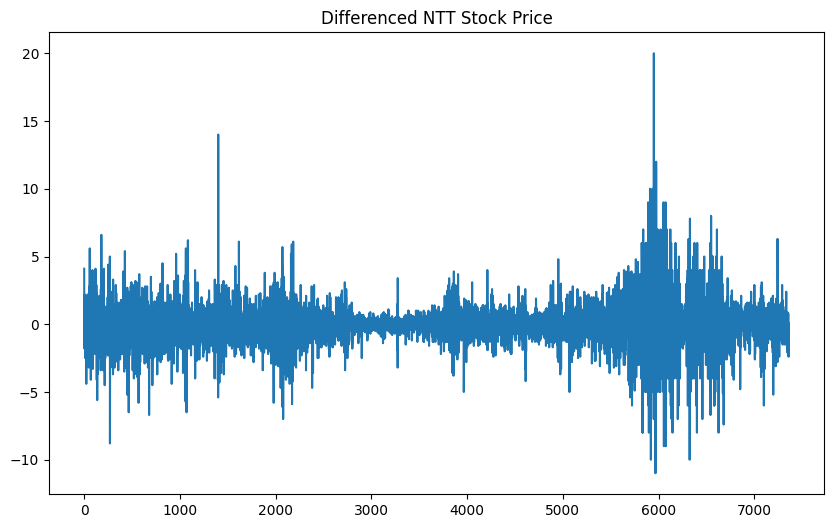

ADF Statistic (Differenced): -22.25893703689893
p-value (Differenced): 0.0


In [18]:
data_diff = train_data['Close Price'].diff().dropna()

# Plot the differenced data
plt.figure(figsize=(10,6))
plt.plot(data_diff, label='Differenced Stock Price')
plt.title('Differenced NTT Stock Price')
plt.show()

# Re-run ADF test
result_diff = adfuller(data_diff)
print(f'ADF Statistic (Differenced): {result_diff[0]}')
print(f'p-value (Differenced): {result_diff[1]}')


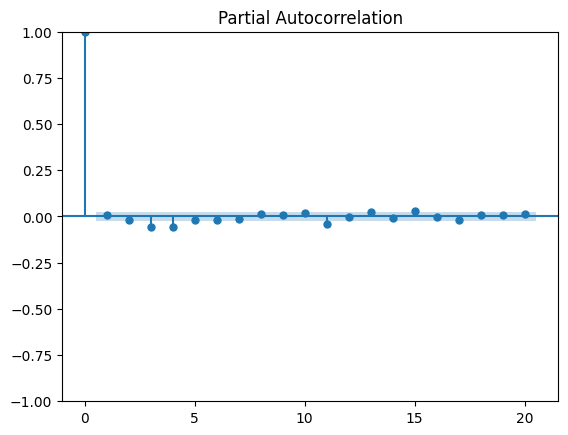

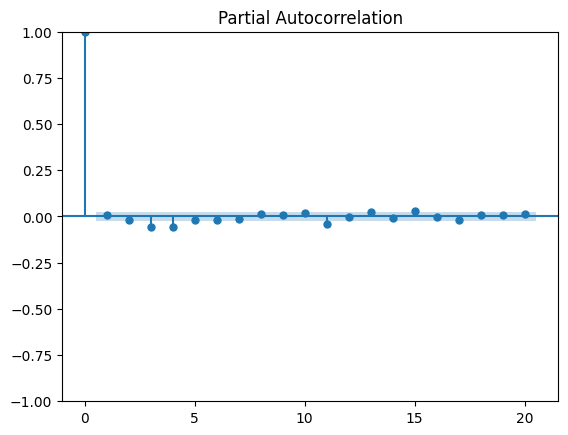

In [19]:
plot_pacf(data_diff, lags=20)


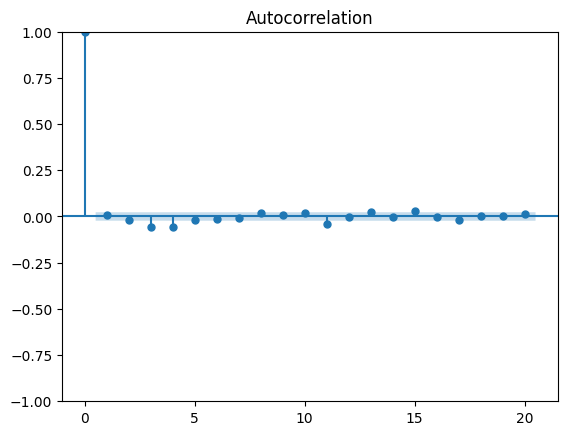

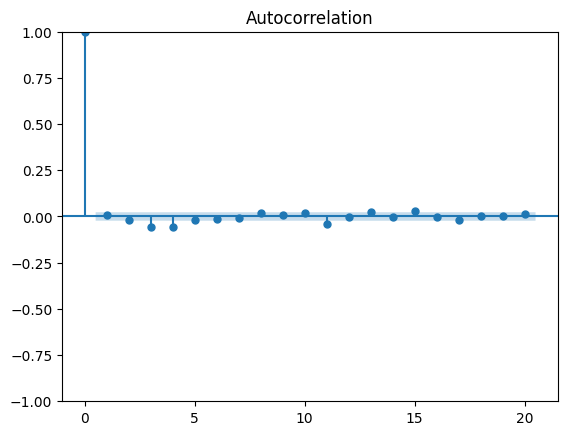

In [20]:
plot_acf(data_diff, lags=20)

In [21]:
# Define the model (use appropriate p, d, q values)
model = ARIMA(train_data['Close Price'], order=(2,1,2))

# Fit the model
model_fit = model.fit()

# Print summary of the model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:            Close Price   No. Observations:                 7361
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -13776.376
Date:                Wed, 09 Oct 2024   AIC                          27562.752
Time:                        05:44:22   BIC                          27597.271
Sample:                             0   HQIC                         27574.616
                               - 7361                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2580      0.074     17.049      0.000       1.113       1.403
ar.L2         -0.5492      0.062     -8.822      0.000      -0.671      -0.427
ma.L1         -1.2494      0.077    -16.217      0.0

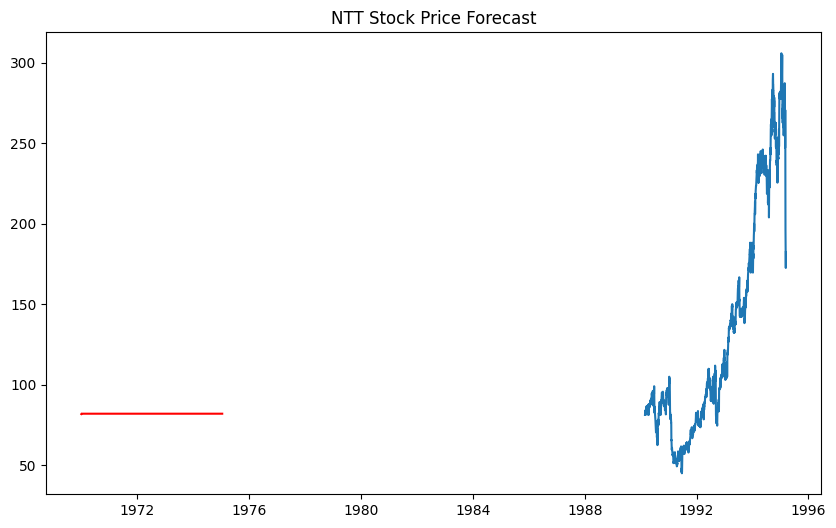

In [22]:
# Forecast the next 10 days
forecast = model_fit.forecast(steps=len(test_data))
# print(forecast)

# Plot the forecast
plt.figure(figsize=(10,6))
plt.plot(test_data['Close Price'], label='Original')
plt.plot(pd.date_range(test_data.index[-1], periods=len(test_data), freq='D'), forecast, label='Forecast', color='red')
plt.title('NTT Stock Price Forecast')
plt.show()


In [23]:
from sklearn.metrics import mean_squared_error
import numpy as np

predictions = model_fit.predict(start=0, end=len(test_data)-1)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data['Close Price'], predictions))
print(f'RMSE: {rmse}')


RMSE: 90.43482426906402


#N-BEATS

In [24]:
# Preparing data for N-Beats model
close_prices = data['Close Price'].values

# Define a function to create input-output sequences for time series prediction
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [25]:
# Define the N-Beats model using TensorFlow
def build_nbeats_model(input_size):
    model = models.Sequential([
        layers.InputLayer(input_shape=(input_size,)),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(1)  # Output layer with a single value prediction (close price)
    ])
    return model

In [26]:
# Define sequence length and split data into training and test sets
SEQ_LENGTH = 30  # 30 days of historical data
X, y = create_sequences(close_prices, SEQ_LENGTH)

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize the N-Beats model
nbeats_model_tf = build_nbeats_model(SEQ_LENGTH)

# Compile the model
nbeats_model_tf.compile(optimizer='adam', loss='mse')

# Train the model
history = nbeats_model_tf.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/40


c:\WorkSpace\Tech Japan OA test\Assignment\venv\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 260.9347 - val_loss: 33.2332
Epoch 2/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.9118 - val_loss: 73.7579
Epoch 3/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.8897 - val_loss: 35.0288
Epoch 4/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.8358 - val_loss: 30.3126
Epoch 5/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.2269 - val_loss: 17.9675
Epoch 6/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.0871 - val_loss: 41.0550
Epoch 7/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.1277 - val_loss: 19.1827
Epoch 8/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.2039 - val_loss: 33.1115
Epoch 9/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.5513 - val_loss: 17.7865
Epoch 10/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.3875 - val_loss: 39.3613
Epoch 11/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.9507 - val_loss: 19.5459
Epoch 12/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/st

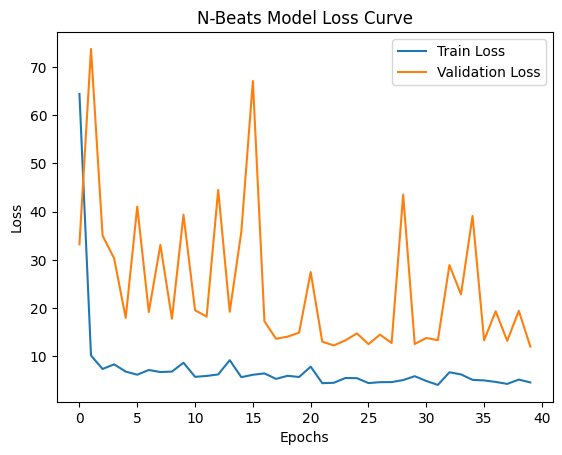

In [27]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('N-Beats Model Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Result Compilation

In [28]:
# LSTM Evaluation Metrics (already in your code)
lstm_mae = mean_absolute_error(actual_prices, lstm_predictions)
lstm_mse = mean_squared_error(actual_prices, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)


# ARIMA Evaluation Metrics
predictions = model_fit.predict(start=0, end=len(test_data)-1)
arima_rmse = np.sqrt(mean_squared_error(test_data['Close Price'], predictions))
arima_mae = mean_absolute_error(test_data['Close Price'], predictions)
arima_mse = mean_squared_error(test_data['Close Price'], predictions)


# N-BEATS Evaluation Metrics
nbeats_predictions = nbeats_model_tf.predict(X_test)
nbeats_rmse = np.sqrt(mean_squared_error(y_test, nbeats_predictions))
nbeats_mae = mean_absolute_error(y_test, nbeats_predictions)
nbeats_mse = mean_squared_error(y_test, nbeats_predictions)

# Compile Results
print("\n--- Model Evaluation Results ---")
print("LSTM:")
print(f"  MAE: {lstm_mae}")
print(f"  MSE: {lstm_mse}")
print(f"  RMSE: {lstm_rmse}")

print("\nARIMA:")
print(f"  MAE: {arima_mae}")
print(f"  MSE: {arima_mse}")
print(f"  RMSE: {arima_rmse}")

print("\nN-BEATS:")
print(f"  MAE: {nbeats_mae}")
print(f"  MSE: {nbeats_mse}")
print(f"  RMSE: {nbeats_rmse}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Model Evaluation Results ---
LSTM:
  MAE: 4.16000335709936
  MSE: 36.232068520427426
  RMSE: 6.01930797687138

ARIMA:
  MAE: 76.98834172596776
  MSE: 8178.457440576492
  RMSE: 90.43482426906402

N-BEATS:
  MAE: 2.0783825887321448
  MSE: 12.008502233069786
  RMSE: 3.4653285894803374


# Hypothesis (N-BEATS)
Introducing additional features such as moving averages (SMA), exponential moving averages (EMA), and volatility will help the N-BEATS model capture more nuanced trends and patterns in the stock price data, improving its predictive accuracy.

## Loading Data

In [29]:
# Load the dataset
df = pd.read_csv('stock_price.csv')

# Display the first few rows to verify
df.head()

,日付け,終値,始値,高値,安値,出来高,変化率 %
0,2024-08-01,156.3,159.3,159.4,156.1,79.15M,-2.56%
1,2024-07-31,160.4,158.2,160.7,158.1,173.91M,1.07%
2,2024-07-30,158.7,158.8,159.2,158.0,138.14M,-0.63%
3,2024-07-29,159.7,158.7,160.2,158.4,126.28M,1.14%
4,2024-07-26,157.9,159.3,159.6,157.9,155.08M,-0.13%


In [30]:
# Rename columns
df.columns = ['Date', 'Close Price', 'Open Price', 'High Price', 'Low Price', 'Volume', 'Change Rate %']

# Display the updated columns
print(df.columns)

Index(['Date', 'Close Price', 'Open Price', 'High Price', 'Low Price',
       'Volume', 'Change Rate %'],
      dtype='object')


## Implementig Feature Engineering for N-BEATS

In [31]:
# Feature engineering: Calculate SMA, EMA, and Volatility
df['SMA_10'] = df['Close Price'].rolling(window=10).mean()
df['EMA_10'] = df['Close Price'].ewm(span=10, adjust=False).mean()
df['Volatility'] = df['Close Price'].rolling(window=10).std()

# Drop NA values generated from rolling windows
df.dropna(inplace=True)

# Prepare data for N-BEATS
n_beats_features = ['Close Price', 'SMA_10', 'EMA_10', 'Volatility']
X_nbeats = df[n_beats_features].values
y_nbeats = df['Close Price'].values

# Split data into training and testing sets
train_size = int(len(X_nbeats) * 0.8)
X_train_nbeats, X_test_nbeats = X_nbeats[:train_size], X_nbeats[train_size:]
y_train_nbeats, y_test_nbeats = y_nbeats[:train_size], y_nbeats[train_size:]

# Retrain the N-BEATS model using the new features
SEQ = 4
nbeats_model = build_nbeats_model(SEQ)

# Compile the model
nbeats_model.compile(optimizer='adam', loss='mse')

nbeats_model.fit(X_train_nbeats, y_train_nbeats, epochs=50, batch_size=32, validation_data=(X_test_nbeats, y_test_nbeats))

Epoch 1/50


c:\WorkSpace\Tech Japan OA test\Assignment\venv\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 355.8621 - val_loss: 7.1177
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2089 - val_loss: 5.4231
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5802 - val_loss: 0.5329
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0349 - val_loss: 0.2834
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0082 - val_loss: 0.1988
Epoch 6/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0056 - val_loss: 0.1896
Epoch 7/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0341 - val_loss: 0.2440
Epoch 8/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2327 - val_loss: 0.6296
Epoch 9/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0551 - val_loss: 13.3441
Epoch 10/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.4153 - val_loss: 0.1719
Epoch 11/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0735 - val_loss: 0.1808
Epoch 12/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss:

## Results of Hypothesis

In [32]:
# Evaluate the model
nbeats_predictions = nbeats_model.predict(X_test_nbeats)
nbeats_mae = mean_absolute_error(y_test_nbeats, nbeats_predictions)
nbeats_mse = mean_squared_error(y_test_nbeats, nbeats_predictions)
nbeats_rmse = np.sqrt(mean_squared_error(y_test_nbeats, nbeats_predictions))

print(f"N-BEATS with new features - MAE: {nbeats_mae}, MSE:{nbeats_mse}, RMSE: {nbeats_rmse}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
N-BEATS with new features - MAE: 0.2998842534972248, MSE:0.1382319732472837, RMSE: 0.3717956068154702
